## 1. Motivation and Context

In previous sections, the polynomial regression task was formulated as a least-squares optimization problem:

$$
\min_\beta \|X\beta - y\|_2^2
$$

where the numerical conditioning of the design matrix $X$ is contingent upon the chosen basis functions and feature scaling. We previously established that regularization (e.g., Ridge regression) or implicit biases inherent in iterative solvers are necessary to stabilize this optimization.

This section investigates how these stability mechanics manifest as the **double-descent phenomenon**—a modern reformulation of the bias–variance trade-off specifically within overparameterized regimes.

=== Experiment Configuration ===
Function:      quadratic
Basis:         legendre
Domain:        [-1.0, 1.0]
Datasets (K):  300
Samples (N):   15
Noise σ:       0.2
Degrees:       1–59
Pseudoinverse cutoff (rcond): 1e-12
Generated 300 datasets with 15 samples each.
Test grid: 1000 points from -1.0 to 1.0


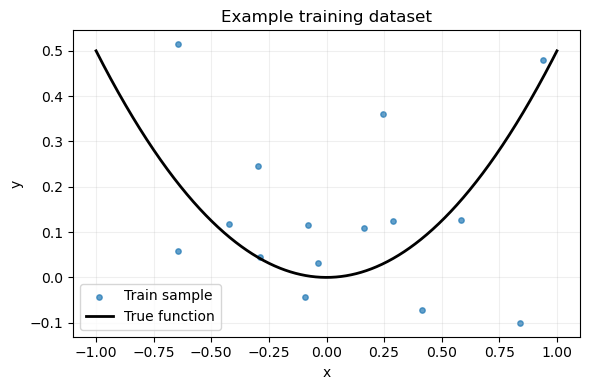

In [1]:
# ================================================================
# CODE BLOCK 1: Setup for the Double Descent Experiment
# ================================================================

import torch, numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Global configuration ----------
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_dtype(torch.float64)

# Switches controlling experiment design
FUNCTION     = "quadratic"       # 'sine' (not representable by finite polynomial) or 'quadratic'
BASIS        = "legendre"      # 'power' → ill-conditioned (shows spike), 'legendre' → stable
DOMAIN_MIN   = -1.0         # widen domain to accentuate variance
DOMAIN_MAX   =  1.0
K_DATASETS   = 300          # number of distinct training sets (for E_D[·])
N_SAMPLES    = 15           # samples per dataset  → interpolation threshold ≈ 14
SIGMA_NOISE  = 0.2          # noise standard deviation
TEST_SIZE    = 1000         # test grid points
RCOND        = 1e-12         # pseudoinverse cutoff (acts like small ridge)
DEGREES      = range(1, 60) # model degrees to sweep through

# ---------- 2. True function ----------
def true_function(x):
    if FUNCTION == "sine":
        return torch.sin(2 * torch.pi * x)
    elif FUNCTION == "quadratic":
        return 0.5 * x**2
    else:
        raise ValueError(f"Unknown FUNCTION={FUNCTION}")

# ---------- 3. Data generator ----------
def generate_ensemble(K, N, sigma, a=DOMAIN_MIN, b=DOMAIN_MAX):
    """
    Generate K datasets each with N samples from x∈[a,b],
    following y = f(x) + ε, ε~N(0,σ²)
    """
    X = torch.rand(K, N) * (b - a) + a
    y = true_function(X) + sigma * torch.randn(K, N)
    return X, y

# ---------- 4. Basis functions ----------
def power_basis(x, degree):
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def legendre_basis(x, degree):
    P0 = torch.ones_like(x)
    if degree == 0:
        return P0.unsqueeze(-1)
    P1 = x
    Ps = [P0, P1]
    for n in range(2, degree + 1):
        Pn = ((2*n - 1) * x * Ps[-1] - (n - 1) * Ps[-2]) / n
        Ps.append(Pn)
    return torch.stack(Ps[:degree+1], dim=-1)

def make_basis(X, degree, name=BASIS):
    if name == "power":
        return power_basis(X, degree)
    elif name == "legendre":
        # map to [-1,1] for orthogonal polynomials
        X_mapped = 2 * (X - DOMAIN_MIN) / (DOMAIN_MAX - DOMAIN_MIN) - 1.0
        return legendre_basis(X_mapped, degree)
    else:
        raise ValueError(name)

# ---------- 5. Pseudoinverse solver ----------
def fit_ensemble(X_train, y_train, degree, basis_name=BASIS, rcond=RCOND):
    Phi = make_basis(X_train, degree, basis_name)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)   # minimum-norm LS with cutoff
    betas = torch.matmul(Phi_pinv, y_train.unsqueeze(-1))
    return betas.squeeze(-1)  # shape: (K, d+1)

# ---------- 6. Generate ensembles ----------
X_train_K, y_train_K = generate_ensemble(K_DATASETS, N_SAMPLES, SIGMA_NOISE)

# ---------- 7. Fixed test grid ----------
X_test = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, TEST_SIZE).view(-1, 1)
y_test_true = true_function(X_test)

# ---------- 8. Summary ----------
print("=== Experiment Configuration ===")
print(f"Function:      {FUNCTION}")
print(f"Basis:         {BASIS}")
print(f"Domain:        [{DOMAIN_MIN}, {DOMAIN_MAX}]")
print(f"Datasets (K):  {K_DATASETS}")
print(f"Samples (N):   {N_SAMPLES}")
print(f"Noise σ:       {SIGMA_NOISE}")
print(f"Degrees:       1–{max(DEGREES)}")
print(f"Pseudoinverse cutoff (rcond): {RCOND}")
print("="*40)
print(f"Generated {K_DATASETS} datasets with {N_SAMPLES} samples each.")
print(f"Test grid: {TEST_SIZE} points from {DOMAIN_MIN} to {DOMAIN_MAX}")

# Optional quick look at one dataset
plt.figure(figsize=(6,4))
plt.scatter(X_train_K[0], y_train_K[0], s=15, color='tab:blue', alpha=0.7, label='Train sample')
plt.plot(X_test, y_test_true, color='black', lw=2, label='True function')
plt.title("Example training dataset")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True, alpha=0.2)
plt.tight_layout(); plt.show()


## 2. Experimental Setup

The following experiment empirically reproduces double descent to interpret it through the lens of numerical optimization.

**Model Class:**
We employ unregularized polynomial regressors $f_d(x)$ with degrees $d$ ranging from the under-parameterized to the over-parameterized regime:

$$
f_d(x)=\sum_{i=0}^d \beta_i x^i
$$

**Data Generation Process:**
The underlying true function is defined as $f(x)=\sin(2\pi x)$. As this function is transcendental, it is not representable by any finite polynomial, ensuring a non-zero bias. Additive Gaussian noise is introduced to simulate data uncertainty:

$$
y=f(x)+\varepsilon, \quad \varepsilon\sim\mathcal{N}(0,\sigma^2)
$$

This noise component is critical for exposing the variance spike characteristic of double descent.

**Conditioning and Regularization:**
* **Bases:** We contrast the Power (Vandermonde) basis, which is inherently ill-conditioned, against the Legendre basis, which is orthogonal. This comparison isolates the role of conditioning in generalization.
* **Regularization:** We utilize the reciprocal condition number (`rcond`) as a proxy for implicit ridge regularization. Varying this cutoff allows us to toggle between unstable and stable regimes.

In [2]:
# ================================================================
# CODE BLOCK 2: Bias–Variance Experiment Loop (stores all histories)
# ================================================================
# This loop implements the "Experimental Setup" section:
#  - Fits unregularized polynomial models f_d(x) = sum β_i x^i.
#  - True function f(x) = sin(2πx) ensures nonzero bias.
#  - Gaussian noise ε~N(0,σ²) exposes the variance spike.
#  - Power (Vandermonde) basis -> ill-conditioned -> double descent.
#  - Legendre basis -> orthogonal -> stable regime.
#  - Pseudoinverse cutoff rcond acts as implicit ridge regularization.

# Histories to be filled
degrees              = list(DEGREES)
bias_squared_history = []
variance_history     = []
mse_clean_history    = []  # E[(f_hat - f)^2] = Bias^2 + Var
mse_noisy_history    = []  # E[(f_hat - y)^2] = Bias^2 + Var + sigma^2
avg_norm_history     = []  # ||beta||_2 averaged across K (for Block 5)

print(f"[Loop] Starting double-descent experiment: basis={BASIS}, function={FUNCTION}, "
      f"N={N_SAMPLES}, σ={SIGMA_NOISE}, degrees 1..{max(degrees)}, rcond={RCOND}")

for d in degrees:
    # 1) Fit all K models at degree d (minimum-norm LS with cutoff RCOND)
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=RCOND)  # (K, d+1)

    # 2) Parameter norms (for Block 5)
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)

    # 3) Build test basis and predict
    Phi_test = make_basis(X_test.squeeze(-1), d, BASIS)   # (T, d+1)
    y_preds  = torch.matmul(betas, Phi_test.T)            # (K, T)

    # 4) Bias–Variance decomposition on the test grid
    # Expected prediction over datasets (K): shape (T,)
    main_pred = torch.mean(y_preds, dim=0)

    # Bias^2: average over test points
    bias_sq = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()

    # Variance: variance across datasets (dim=0), then average over test points
    variance = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()

    # Clean test MSE against noiseless labels f(x): Bias^2 + Var
    mse_clean = torch.mean((y_preds - y_test_true.T) ** 2).item()

    # Noisy test MSE against labels y = f + ε (what many call "test error"): add σ^2
    mse_noisy = mse_clean + (SIGMA_NOISE ** 2)

    # 5) Store
    bias_squared_history.append(bias_sq)
    variance_history.append(variance)
    mse_clean_history.append(mse_clean)
    mse_noisy_history.append(mse_noisy)

    # Progress log
    if d % 10 == 0 or d == degrees[0] or d == degrees[-1]:
        print(f"  degree {d:3d} | Risk(noisy)={mse_noisy:10.4e} | Bias²={bias_sq:10.4e} "
              f"| Var={variance:10.4e} | ||β||₂(avg)={avg_norm:9.3e}")

print("[Loop] Done. Histories available:")
print(" - bias_squared_history, variance_history")
print(" - mse_clean_history (Bias²+Var), mse_noisy_history (Bias²+Var+σ²)")
print(" - avg_norm_history (for Block 5)")


[Loop] Starting double-descent experiment: basis=legendre, function=quadratic, N=15, σ=0.2, degrees 1..59, rcond=1e-12
  degree   1 | Risk(noisy)=7.2759e-02 | Bias²=2.2503e-02 | Var=1.0256e-02 | ||β||₂(avg)=2.021e-01
  degree  10 | Risk(noisy)=4.0205e+09 | Bias²=2.9840e+07 | Var=3.9907e+09 | ||β||₂(avg)=1.320e+04
  degree  20 | Risk(noisy)=3.7112e+12 | Bias²=1.1858e+10 | Var=3.6993e+12 | ||β||₂(avg)=5.844e+05
  degree  30 | Risk(noisy)=1.8198e+08 | Bias²=6.0151e+05 | Var=1.8138e+08 | ||β||₂(avg)=5.881e+03
  degree  40 | Risk(noisy)=2.2460e+05 | Bias²=4.3520e+02 | Var=2.2417e+05 | ||β||₂(avg)=3.434e+02
  degree  50 | Risk(noisy)=1.0988e+04 | Bias²=2.7573e+01 | Var=1.0961e+04 | ||β||₂(avg)=1.066e+02
  degree  59 | Risk(noisy)=3.9121e+03 | Bias²=1.0587e+01 | Var=3.9015e+03 | ||β||₂(avg)=6.206e+01
[Loop] Done. Histories available:
 - bias_squared_history, variance_history
 - mse_clean_history (Bias²+Var), mse_noisy_history (Bias²+Var+σ²)
 - avg_norm_history (for Block 5)


## 3. Bias–Variance Decomposition and Double Descent

The observed test error curves can be formally analyzed via the bias-variance decomposition. For any estimator $\hat{f}(x)$:

$$
\mathbb{E}\left[(\hat{f}(x)-f(x))^2\right] = \text{Bias}^2(x) + \text{Var}(x) + \sigma^2
$$

* **Bias:** Decreases monotonically as model capacity (degree $d$) increases.
* **Variance:** Exhibits a sharp peak near the interpolation threshold ($p=n$), where the model captures the noise $\varepsilon$.

The summation of these components results in the double-descent shape. The magnitude of the variance spike is functionally dependent on:
1.  The condition number of the Gram matrix $X^TX$.
2.  The irreducible noise level $\sigma^2$.
3.  The presence of explicit or implicit regularization mechanisms.

Computing Robust Metrics (d=1..30)...


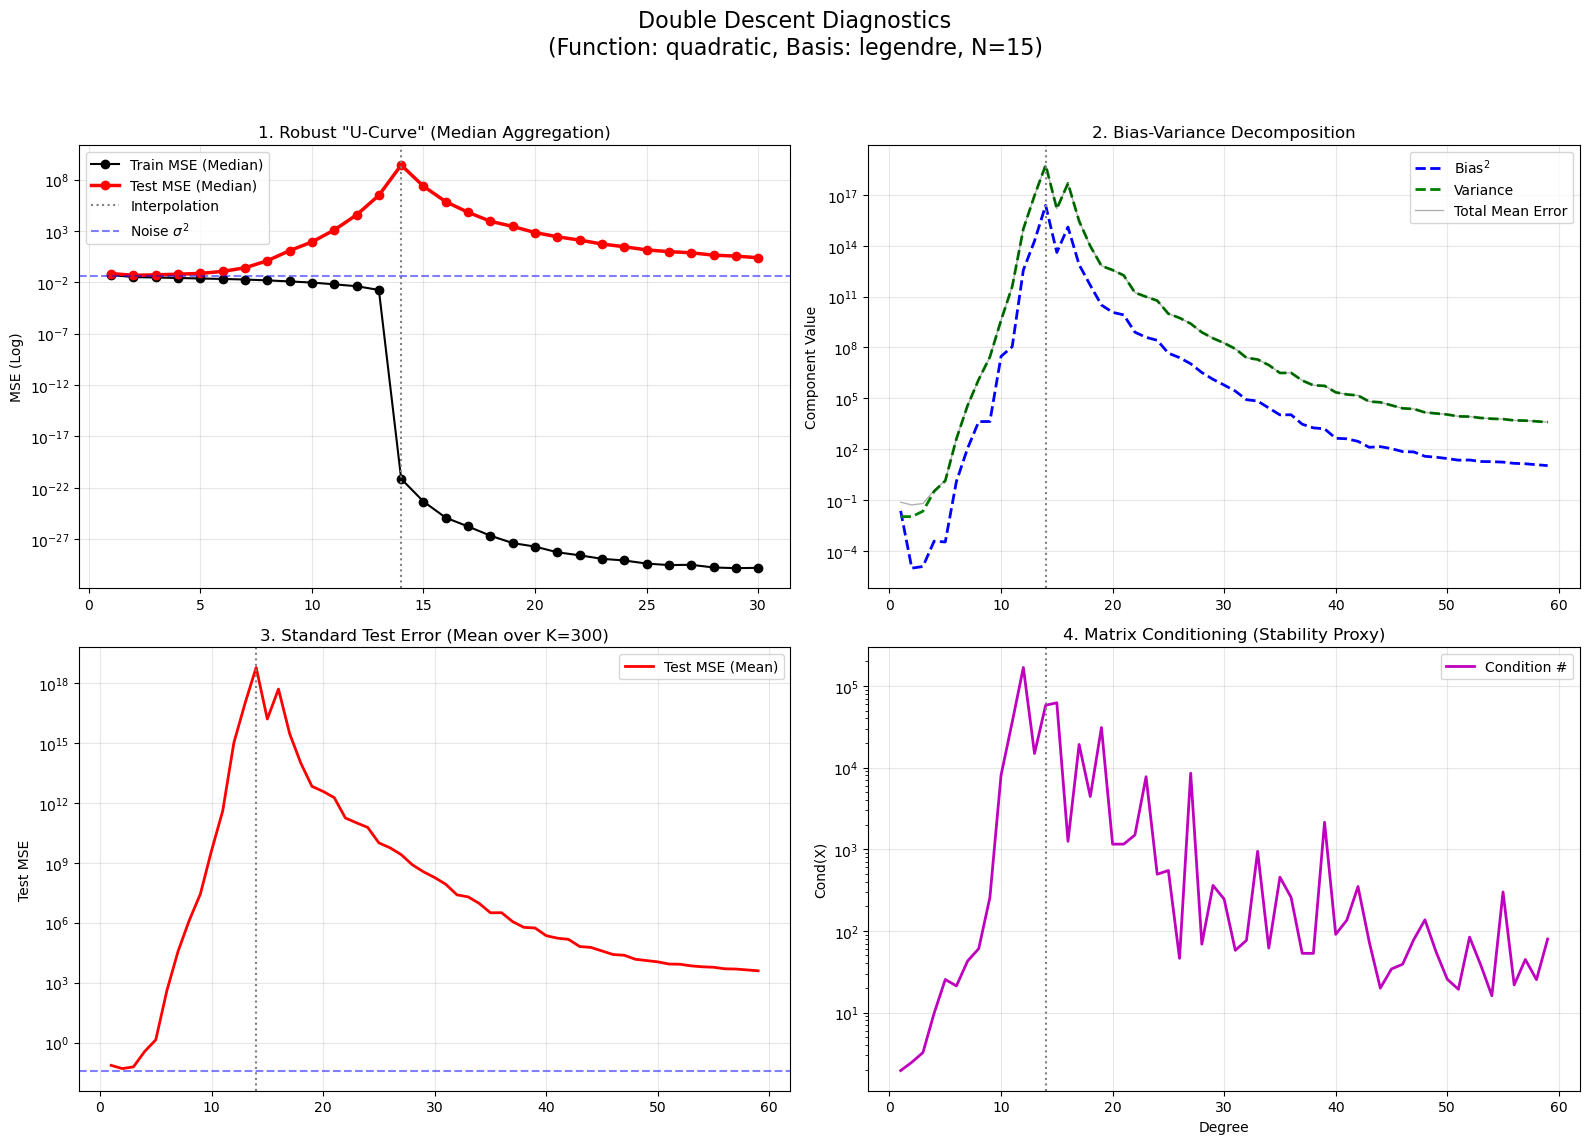

In [13]:
# ================================================================
# CODE BLOCK 3: Comprehensive Double Descent Analysis (2x2 Panel)
# ================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Safety Checks & Data Prep ---
assert 'degrees' in globals() and len(degrees) > 0, "Run Block 2 first."
assert 'mse_noisy_history' in globals(), "Missing history from Block 2."

deg_full = np.array(list(degrees))
bias_np  = np.asarray(bias_squared_history, dtype=float)
var_np   = np.asarray(variance_history,     dtype=float)
mse_mean = np.asarray(mse_noisy_history,    dtype=float)
sigma2   = float(SIGMA_NOISE**2)
thresh_d = N_SAMPLES - 1

def _clean_log(a, eps=1e-12):
    """Handles zeros/nans for log-plotting."""
    a = np.nan_to_num(a, nan=0.0, posinf=np.nanmax(a[np.isfinite(a)]) if np.any(np.isfinite(a)) else 1.0)
    a[a <= 0] = eps
    return a

# Helper to calc condition number
def _median_cond_over_k(Phi_batch, sample_k=10):
    Ks = min(sample_k, Phi_batch.shape[0])
    idx = torch.randperm(Phi_batch.shape[0])[:Ks]
    conds = []
    for k in idx:
        try:
            # SVD to get singular values (sigma_max / sigma_min)
            _, S, _ = torch.linalg.svd(Phi_batch[k], full_matrices=False)
            smax = torch.max(S).item()
            smin = max(torch.min(S).item(), 1e-300)
            conds.append(smax / smin)
        except:
            conds.append(np.nan)
    return float(np.median(conds)) if conds else np.nan

# Setup the 2x2 Grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Double Descent Diagnostics\n(Function: {FUNCTION}, Basis: {BASIS}, N={N_SAMPLES})', fontsize=16)

# ==============================================================================
# SUBPLOT 1 (Top-Left): Robust Median Analysis (The U-Curve)
# ==============================================================================
# Re-calculates Median Train/Test error for d=1..30 using low rcond to force interpolation.
# This reveals the "Textbook" curves hidden by numerical outliers.
ax = axs[0, 0]

# Zoom in for clear U-curve view
zoom_limit = 30
plot_degrees = [d for d in degrees if d <= zoom_limit]
robust_rcond = 1e-15 # Force solver to fit data even if unstable

# Generate clean test grid for validation
rng_state = torch.random.get_rng_state()
torch.manual_seed(42)
X_test_clean = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, 1000).unsqueeze(-1)
y_test_clean = true_function(X_test_clean)
y_test_noisy = y_test_clean + SIGMA_NOISE * torch.randn_like(y_test_clean)
torch.random.set_rng_state(rng_state)

train_med, test_med = [], []

print(f"Computing Robust Metrics (d=1..{zoom_limit})...")
for d in plot_degrees:
    # Fit Ensemble (All K datasets)
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=robust_rcond)
    
    # Train Error (Median)
    Phi_tr = make_basis(X_train_K, d, BASIS)
    y_pred_tr = torch.einsum('kd,knd->kn', betas, Phi_tr) # Shape (K, N)
    mse_k_tr = torch.mean((y_pred_tr - y_train_K)**2, dim=1)
    train_med.append(torch.median(mse_k_tr).item())
    
    # Test Error (Median)
    Phi_te = make_basis(X_test_clean.squeeze(-1), d, BASIS)
    y_pred_te = torch.matmul(betas, Phi_te.T) # Shape (K, T)
    # Compare against noisy test data (broadcast)
    mse_k_te = torch.mean((y_pred_te - y_test_noisy.squeeze())**2, dim=1)
    test_med.append(torch.median(mse_k_te).item())

deg_z = np.array(plot_degrees)
ax.plot(deg_z, _clean_log(np.array(train_med)), 'k-o', lw=1.5, label='Train MSE (Median)')
ax.plot(deg_z, _clean_log(np.array(test_med)), 'r-o', lw=2.5, label='Test MSE (Median)')
ax.axvline(x=thresh_d, color='gray', ls=':', label='Interpolation')
ax.axhline(y=sigma2, color='blue', ls='--', alpha=0.5, label='Noise $\sigma^2$')
ax.set_yscale('log')
ax.set_title('1. Robust "U-Curve" (Median Aggregation)')
ax.set_ylabel('MSE (Log)')
ax.legend()
ax.grid(alpha=0.3)

# ==============================================================================
# SUBPLOT 2 (Top-Right): Bias-Variance Decomposition
# ==============================================================================
# Plots the components calculated in Block 2
ax = axs[0, 1]
ax.plot(deg_full, _clean_log(bias_np), 'b--', lw=2, label='Bias$^2$')
ax.plot(deg_full, _clean_log(var_np),  'g--', lw=2, label='Variance')
# Also show Total Mean Error to see how they sum up
ax.plot(deg_full, _clean_log(mse_mean), 'k-', lw=1, alpha=0.3, label='Total Mean Error')

ax.axvline(x=thresh_d, color='gray', ls=':')
ax.set_yscale('log')
ax.set_title('2. Bias-Variance Decomposition')
ax.set_ylabel('Component Value')
ax.legend()
ax.grid(alpha=0.3)

# ==============================================================================
# SUBPLOT 3 (Bottom-Left): Standard Test Error (Mean)
# ==============================================================================
# Shows the "Standard" Double Descent curve (Mean MSE). 
# Note: If Power basis is used, this may explode due to outliers (unlike Plot 1).
ax = axs[1, 0]
ax.plot(deg_full, _clean_log(mse_mean), 'r-', lw=2, label='Test MSE (Mean)')
ax.axhline(y=sigma2, color='blue', ls='--', alpha=0.5)
ax.axvline(x=thresh_d, color='gray', ls=':')
ax.set_yscale('log')
ax.set_title(f'3. Standard Test Error (Mean over K={K_DATASETS})')
ax.set_ylabel('Test MSE')
ax.legend()
ax.grid(alpha=0.3)

# ==============================================================================
# SUBPLOT 4 (Bottom-Right): Numerical Conditioning
# ==============================================================================
# Proxies the variance spike by showing condition number of design matrix.
ax = axs[1, 1]
cond_history = []
# Calculate cond for a subset of degrees to save time if array is huge
calc_degrees = deg_full[::1] # Step=1 (calculate all)
for d in calc_degrees:
    # Reuse X_train_K from Block 1
    Phi_all = make_basis(X_train_K, int(d), BASIS) 
    cond_history.append(_median_cond_over_k(Phi_all, sample_k=5))

ax.plot(calc_degrees, _clean_log(np.array(cond_history)), 'm-', lw=2, label='Condition #')
ax.axvline(x=thresh_d, color='gray', ls=':')
ax.set_yscale('log')
ax.set_title('4. Matrix Conditioning (Stability Proxy)')
ax.set_ylabel('Cond(X)')
ax.set_xlabel('Degree')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Interpreting Regularization, Scaling, and Iterative Solvers

The empirical behavior of the model is directly tied to optimization theory concepts established in earlier sections:

* **Legendre Basis & Feature Scaling:** Orthogonalization effectively minimizes the condition number of the design matrix, suppressing the variance spike and stabilizing the solution.
* **Ridge Regression (Explicit Regularization):** The addition of a penalty term $\lambda\|\beta\|^2$ constrains the solution space, resulting in a smooth single-descent curve.
* **Iterative Solvers:** Algorithms such as Gradient Descent (GD), Conjugate Gradient (CG), or BFGS introduce **implicit regularization** via step-size constraints and stopping criteria. Even in the absence of an explicit penalty, small-step GD tends to converge toward minimum-norm solutions, thereby reducing the interpolation spike.

Consequently, double descent is not a paradox, but a visible symptom of optimization instability in the absence of sufficient constraints.

## 5. From Polynomials to Neural Networks

This polynomial regression experiment serves as a low-dimensional analogue for large-scale learning systems. The structural dynamics map as follows:

| Polynomial Regression | Deep Learning |
| :--- | :--- |
| Degree ($d$) | Number of parameters / layers |
| Vandermonde Ill-conditioning | Poorly scaled Jacobians / Feature maps |
| Ridge / `rcond` | Weight decay / Early stopping |
| Gradient Descent Implicit Bias | SGD Implicit Bias |
| Variance spike at $p=n$ | Test-error bump near interpolation threshold |

Despite the difference in scale, both systems obey identical bias–variance dynamics governed by the conditioning of the optimization landscape and the regularization applied.

## 6. Summary

The double-descent phenomenon demonstrates that test error may decrease, increase, and decrease again as model capacity grows.

* **Mechanism:** The phenomenon is driven by a variance explosion near the interpolation threshold, caused by the interaction of noise with ill-conditioned design matrices.
* **Mitigation:** Stability is restored through explicit regularization, implicit regularization (via iterative solvers), or improved numerical conditioning (via orthogonal bases).
* **Implication:** Large-scale neural networks effectively interpolate data while maintaining generalization capabilities because their optimization processes incorporate these implicit biases and regularization effects.

Double descent is effectively the visualization of optimization instability in overparameterized models; understanding it in the polynomial case clarifies why conditioning and regularization are prerequisites for generalization in modern machine learning.